
# Building RFM segments

This notebook shows you how to build your very own RFM segments! 

As you learned in the [Customer Segmentation in Python](https://www.datacamp.com/courses/customer-segmentation-in-python) course, RFM stands for Recency, Frequency & Monetary value. Let's get started!


## 1. Import & inspect data

The dataset we will use is provided for you in a csv file. First, we will import this data and check the data types and content. 


In [45]:
# Import Pandas
import pandas as pd

# Load CSV file into Pandas Dataframe
df = pd.read_csv('OnlineData.csv')

# Show data types & first 5 rows
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 4 columns):
CustomerID     150000 non-null int64
InvoiceNo      150000 non-null int64
InvoiceDate    150000 non-null object
TotalSum       150000 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.6+ MB


,CustomerID,InvoiceNo,InvoiceDate,TotalSum
0,7688,159239,2018-11-23,74.25
1,31918,38853,2018-04-02,52.47
2,89980,90014,2018-07-13,76.94
3,131932,9452,2018-01-10,85.06
4,175579,130668,2018-10-05,10.00


## 2. Change data type

As can be seen in the result above, Pandas correctly identified the data types, except for the column InvoiceDate. This column is imported as "object" and not as a "date" data type. We will adjust our Pandas read_csv-function so Pandas will parse the InvoiceDate column as a "date" data type.


In [46]:
# Create function to parse the InvoiceDate column, which has format YYYY-MM-DD
date_parser = lambda x : pd.datetime.strptime(x, '%Y-%m-%d')

# Create Dataframe & parse column InvoiceDate as "date" data type
data = pd.read_csv('OnlineData.csv', parse_dates=['InvoiceDate'], date_parser=date_parser)

# Show data types & first 5 rows
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 4 columns):
CustomerID     150000 non-null int64
InvoiceNo      150000 non-null int64
InvoiceDate    150000 non-null datetime64[ns]
TotalSum       150000 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 4.6 MB


,CustomerID,InvoiceNo,InvoiceDate,TotalSum
0,7688,159239,2018-11-23,74.25
1,31918,38853,2018-04-02,52.47
2,89980,90014,2018-07-13,76.94
3,131932,9452,2018-01-10,85.06
4,175579,130668,2018-10-05,10.00


## 3. Aggregate RFM data by customer

In the real world, sales data is often not directly available by customer, but on a deeper level of detail like an order or an invoice. As our dataset also has this *granularity* on invoice level (meaning 1 row = 1 invoice), we have to aggregate this data on customer level. The data we need by customer are the following:
- Recency - days since last customer transaction
- Frequency - number of transactions in the last 12 months
- Monetary Value - total spend in the last 12 months

As we will see below, our data spans the full calendar year 2018, so for our Recency measure, we will have to 'pretend' (i.e. start counting from) we are on January 1, 2019.



In [47]:
# Min & Max InvoiceDate
print("MinDate : {} - MaxDate : {}".format(data.InvoiceDate.min(), 
                                           data.InvoiceDate.max() ) )

# Snapshot date = Max
import datetime
snapshot_date = data.InvoiceDate.max() + datetime.timedelta(days=1)
print("Snapshot date : {}".format(snapshot_date))



MinDate : 2018-01-01 00:00:00 - MaxDate : 2018-12-31 00:00:00
Snapshot date : 2019-01-01 00:00:00


In [48]:
# Aggregate data by customer
datamart = data.groupby(['CustomerID']).agg({
                'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                'InvoiceNo': 'count',
                'TotalSum': 'sum'})

# Rename columns
datamart.rename(columns = { 'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

# Show data
datamart.info()
datamart.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 83237 entries, 1 to 181678
Data columns (total 3 columns):
MonetaryValue    83237 non-null float64
Frequency        83237 non-null int64
Recency          83237 non-null int64
dtypes: float64(1), int64(2)
memory usage: 2.5 MB


,MonetaryValue,Frequency,Recency
CustomerID,,,
1,130.96,1,127
2,25.00,1,345
4,37.49,2,39
6,114.24,2,202
8,74.98,1,363


## 4.  Calculate percentiles

Great! Now we have the data we need to calculate an RFM score per customer. First, we need to calculate percentiles. As we want a RFM score from 0 to 9, we will calculate deciles for the RFM measures. Attention: for the Recency measure, the more recent a customer has purchased, the better. In contrast with Frequency & MonetaryValue, the lower the value for Recency, the better!


In [61]:
# Create labels for Recency, Frequency & MonetaryValue
labels_recency = range(9,-1,-1)
labels_frequency = range(0,10)
labels_monetary = range(0,10)

# Assign labels to decile groups        
r_deciles = pd.qcut(datamart['Recency'], 10, labels = labels_recency)
f_deciles = pd.qcut(datamart['Frequency'].rank(method='first'), 10, labels = labels_frequency)
m_deciles = pd.qcut(datamart['MonetaryValue'], 10, labels = labels_monetary)

# Create new columns in data with labels
datamart = datamart.assign(R = r_deciles.values)
datamart = datamart.assign(F = f_deciles.values)
datamart = datamart.assign(M = m_deciles.values)

# Show data
datamart.head(10)


,MonetaryValue,Frequency,Recency,F,R,M
CustomerID,,,,,,
1,130.96,1,127,0,4,7
2,25.00,1,345,0,0,2
4,37.49,2,39,6,8,3
6,114.24,2,202,6,3,7
8,74.98,1,363,0,0,6
9,26.99,1,86,0,6,2
11,302.31,3,26,8,8,9
13,65.25,2,94,6,5,5
15,29.99,1,95,0,5,2


## 5. RFM score

Nice work! Now we only have to concatenate the RFM values to get the RFM Segments, and to average the RFM deciles values to calculate the RFM Scores by customer. The RFM Segment and Score will go from 0 (low) to 9 (high).

In [66]:
# Concatenate RFM values to get RFM Segment
def rfm_segment(x): return str(x['R'])+ str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(rfm_segment, axis=1)

# Average RFM decile values to get RFM Score
datamart['RFM_Score'] = datamart[['R','F','M']].mean(axis=1).round()

# Show result
datamart.head()


,MonetaryValue,Frequency,Recency,F,R,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
1,130.96,1,127,0,4,7,407,4.0
2,25.00,1,345,0,0,2,002,1.0
4,37.49,2,39,6,8,3,863,6.0
6,114.24,2,202,6,3,7,367,5.0
8,74.98,1,363,0,0,6,006,2.0


In [70]:
# Check summary statistics by RFM Score
datamart.groupby('RFM_Score').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': ['mean', 'count'] }).round(1)


Recency Frequency MonetaryValue       
             mean      mean          mean  count
RFM_Score                                       
0.0         343.8       1.0          14.5    707
1.0         296.4       1.0          21.7   4895
2.0         247.4       1.0          33.7  10708
3.0         188.5       1.0          46.0  15214
4.0         138.2       1.1          59.2  13607
5.0         113.9       1.4          76.5  10999
6.0         107.2       1.9         115.2   9083
7.0          76.5       2.7         166.6   8218
8.0          45.2       3.9         261.3   6480
9.0          17.7       6.9         454.8   3326

## 6. Prepare data for clustering : I. Check skewness of measures

When we look at the summary statistics by RFM Score, we can see we did a relatively good job dividing our customers in 10 more or less useful segments. However, we decided the number of segments ourselves, which might only be the most optimal option if we have a lot of business knowledge. There is another option to decide the number of RFM segments, which is to let the data speak for itself. We can do this by running the k-means clustering algorithm on our data. Before we run this algorithm, we have to preprocess our data. K-means clustering works best when all variables have a symmetric distribution, the same average values and the same variance. First, we will check the skewness of the variable distributions.


/home/daniel/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


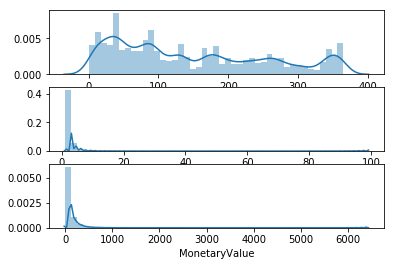

In [78]:
# Import seaborn & matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Show distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(datamart['Recency'])
plt.subplot(3, 1, 2); sns.distplot(datamart['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(datamart['MonetaryValue'])
plt.show()

## 7. Prepare data for clustering : II. Log transform measures

As we can see in the figures above, only the Recency variable has a somewhat symmetric distribution. We will check if we can improve the symmetry of the variable distributions by applying the log transformation.



/home/daniel/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


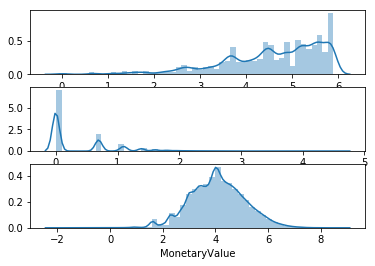

In [80]:
# Import numpy
import numpy as np

# Apply log transformation on 
rfm_log = np.log(datamart[['Recency','Frequency','MonetaryValue']])
rfm_log.head()

# Show distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm_log['Recency'])
plt.subplot(3, 1, 2); sns.distplot(rfm_log['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(rfm_log['MonetaryValue'])
plt.show()


## 8. Prepare data for clustering : III. Standardize measures

The symmetry is already a lot better, especially for the MonetaryValue measure. We also need to standardize our measures to make sure every variable gets the same importance. After applying standardization, our measures will have the same mean (0) and standard deviation (1). This is the last preprocessing step, after which we will run the k-means cluster algorithm on the transformed data.


In [99]:
# Check mean & standard deviation before standardization 
print(rfm_log.describe().round(3))

# Import StandardScaler from sklearn & Instantiate Scaler object
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Standardize measures
scaled_data = scaler.fit_transform(rfm_log)
preprocessed_data = pd.DataFrame(data=scaled_data, index=rfm_log.index, columns=rfm_log.columns)
print(preprocessed_data.head())

# Check mean & standard deviation after standardization 
preprocessed_data.describe().round(3)


         Recency  Frequency  MonetaryValue
count  83237.000  83237.000      83237.000
mean       4.579      0.369          4.079
std        1.084      0.572          1.034
min        0.000      0.000         -2.120
25%        3.912      0.000          3.401
50%        4.812      0.000          4.061
75%        5.464      0.693          4.758
max        5.900      4.595          8.767
             Recency  Frequency  MonetaryValue
CustomerID                                    
1           0.244760  -0.644948       0.769786
2           1.166545  -0.644948      -0.832327
4          -0.844223   0.567339      -0.440318
6           0.672818   0.567339       0.637641
8           1.213456  -0.644948       0.230267


,Recency,Frequency,MonetaryValue
count,83237.000,83237.000,83237.000
mean,0.000,0.000,-0.000
std,1.000,1.000,1.000
min,-4.223,-0.645,-5.998
25%,-0.615,-0.645,-0.656
50%,0.215,-0.645,-0.017
75%,0.816,0.567,0.657
max,1.219,7.392,4.535


## 9. K-Means clustering - elbow method

We will run the k-means clustering algorithm for several different clusters and by using the elbow method, decide about the optimal number of clusters.


In [72]:
datamart.describe()

,MonetaryValue,Frequency,Recency,RFM_Score
count,83237.000000,83237.000000,83237.000000,83237.000000
mean,101.468023,1.802083,147.739611,4.507298
std,145.579703,1.845371,109.435545,2.192485
min,0.120000,1.000000,1.000000,0.000000
25%,29.990000,1.000000,50.000000,3.000000
50%,58.040000,1.000000,123.000000,4.000000
75%,116.510000,2.000000,236.000000,6.000000
max,6416.310000,99.000000,365.000000,9.000000


In [ ]:
df.sort_values('CustomerID', ascending=True).head()

## 2. Aggregate invoice data by customer

The data we will use for creating our RFM segmentation is based invoice 